<div align='center'><font size="5" color='#353B47'>Generate handwritten digits</font></div>
<div align='center'><font size="4" color="#353B47">Generative Adversarial Networks with Keras</font></div>
<br>
<hr>

<div align="justify"><font color="blue" size="4">The purpose of this notebook is to try to implement GANs for handwritten digit images generation. Starting from noise images which have same format than my handwritten digit images, I will try to get closer and closer to distribution of images for each class.</font></div>

# The MNIST dataset

<img src="https://en.mlab.ai/sites/default/files/inline-images/handwritten_numbers.png">

<div align='justify'><font color='blue'>MNIST</font>, or <font color='blue'>M</font>odified <font color='blue'>N</font>ational <font color='blue'>I</font>nstitute of <font color='blue'>S</font>tandards and <font color='blue'>T</font>echnology is a dataset of 70,000 small square 28×28 pixel grayscale images of handwritten digits between 0 and 9.</div>

# Generative Adversarial networks

<div align='justify'><font color='blue'>GAN</font>, or <font color='blue'>G</font>enerative <font color='blue'>A</font>dversarial <font color='blue'>N</font>etworks is an architecture for training generative models. Developing a GAN for generating images requires two essential models:
<br>- A Generator model that uses inverse convolutional layers to transform an input to a full two-dimensional image of pixel values.
<br>- A Discriminator model for classifying whether a given image is real or generated.</div>

<img src="https://weave.eu/app/uploads/2018/03/gan.png" width=1000>

<font color = 'blue' size = 4>How does it work ?</font>

<div align='justify'>The first neural network is called the Generator. It generates fake data points and passes them to its opponent. That’s the second network, the Discriminator. Its job is to tell which data point is real and which is fake. First, we train the Discriminator on a set of real and fake data points. The discriminator guesses what is real and what is fake. After that, we unveil the real solution to it. Based on the feedback, the discriminator learns what is fake and what is not. Once the discriminator is trained, the Generator comes into play. We give him real and fake data points to train with. Based on these points, its job is to make new data points which fool the Discriminator.</div>

<font color = 'blue' size=4>Why not using only real data points ?</font>

<div align='justify'>Indeed, it is easy to think that if you train the discriminator on fake images, then it will repeat the mistakes from those. However, the Generator must not get too good too fast. Otherwise the Discriminator can’t keep up. The Generator has to be misled from time to time so that the Discriminator has a chance to keep up. For example, if the Generator has made fake data. It will try to fool the Discriminator. The Discriminator will hopefully do a reasonable job at differentiating the real data points from the fake ones. It then informs the Generator about its decisions and based on this decision, the Generator will set to work again. It’ll make new fakes, but based on the feedback it will try to make them better so that they fool the Discriminator. Then it’s the Discriminator’s turn again, and so on and so forth. And at the end of the day, we’ve used a GAN to make a heap of new data points.</div>

<font color = 'blue' size=4>Why is it useful ?</font>
<br>


<div align='justify'>It can be used for all kinds of things. For example, make beautiful new pictures, based on others. Deepfake detection...</div>

----
<br>
<div align='justify'>It can be challenging to understand both how GANs work and how deep convolutional neural network models can be trained in a GAN architecture for image generation. A good starting point for beginners is to practice developing and using GANs on standard image datasets used in the field of computer vision, such as the <a href="https://www.kaggle.com/c/digit-recognizer/data">Digit recognizer dataset (MNIST)</a> that includes thousands of handwritten digit images. Using small datasets means that smaller models can be developed and trained quickly, allowing the focus to be put on the model architecture and image generation process itself.
<br><br>
If you are already familair with GANs, I suggest you can go further implementing SOTA GANs models with these must-see <a href="https://www.kaggle.com/getting-started/150948">research papers</a></div>

# 1. Import and load data

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Dense, Dropout, Input, LeakyReLU
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.datasets import mnist
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model, to_categorical

In [2]:
def preprocessing(train, split_train_size = 1/7):

    X_train = train.drop(["label"],
                         axis = 1)
    y_train = train["label"]

    # Reshape into right format vectors
    X_train = X_train.values.reshape(-1,28,28)

    # Apply ohe on labels
    y_train = to_categorical(y_train, num_classes = 10)
    
    # Split the train and the validation set for the fitting
    X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = split_train_size, random_state=42)
    
    return X_train, X_test, y_train, y_test

In [3]:
def load_data(from_MNIST = True):
    
    """
    Return ready to use train and test with images and targets
    from_MNIST = True: load data from keras mnist dataset
    from_MNIST = False: load data from digit-recognizer dataset
    """
    
    if from_MNIST:
    # Load the data from mnist dataset (70k images)
        (x_train, y_train), (x_test, y_test) = mnist.load_data()
    else:
        # Load train from digit recognizer kaggle dataset (42k images)
        train = pd.read_csv('/content/train.csv')
        x_train, x_test, y_train, y_test = preprocessing(train)
    
    # Set pixel values between -1 and 1
    x_train = (x_train.astype(np.float32) - 127.5)/127.5
    
    nb_images_train = x_train.shape[0]
    # convert shape of x_train from (60000, 28, 28) to (60000, 784) 
    # 784 columns per row
    x_train = x_train.reshape(nb_images_train, 784)
    return (x_train, y_train, x_test, y_test)

# 2. Define GAN architecture

In [4]:
def adam_optimizer():
    return Adam(lr=0.0002, beta_1=0.5)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               25856     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              525312    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 784)               8

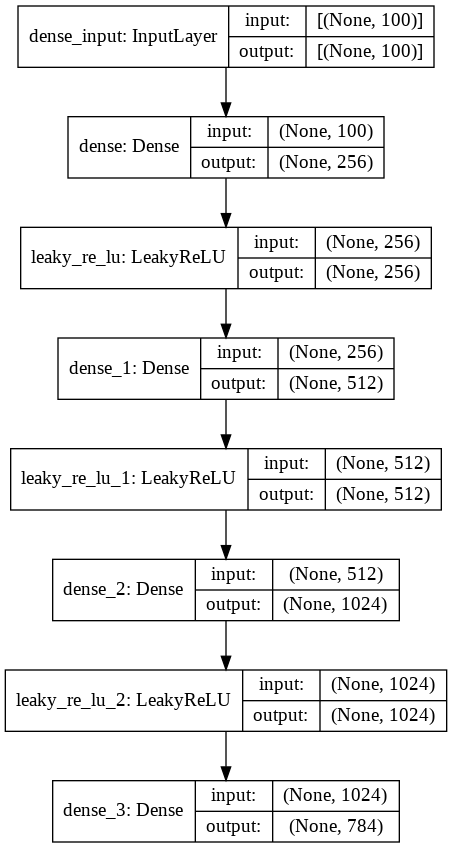

In [5]:
def create_generator():
    
    """
    Create generator architecture
    """
    
    generator=Sequential()
    generator.add(Dense(units=256, input_dim=100))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=512))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=1024))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=784, activation='tanh'))
    
    generator.compile(loss = 'binary_crossentropy', 
                      optimizer = adam_optimizer())
    return generator

g = create_generator()
g.summary()
plot_model(g, show_shapes=True, show_layer_names=True)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 1024)              803840    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 512)               524800    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)              

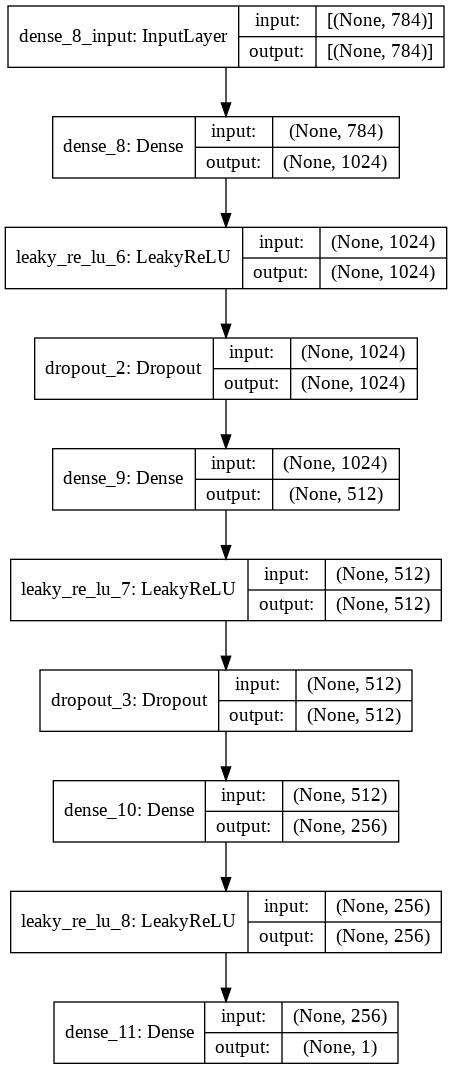

In [7]:
def create_discriminator():
    
    """
    Create discriminator architecture
    """
    
    discriminator = Sequential()
    discriminator.add(Dense(units = 1024, input_dim = 784))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
       
    
    discriminator.add(Dense(units = 512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
       
    discriminator.add(Dense(units=256))
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Dense(units=1, activation='sigmoid'))
    
    discriminator.compile(loss = 'binary_crossentropy', 
                          optimizer = adam_optimizer())
    return discriminator

d = create_discriminator()
d.summary()
plot_model(d, show_shapes=True, show_layer_names=True)

<div align='justify'>We now create the GAN where we combine the Generator and Discriminator. When we train the generator we will freeze the Discriminator. We will input the noised image of shape 100 units to the Generator. The output generated from the Generator will be fed to the Discriminator.</div>

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
sequential (Sequential)      (None, 784)               1486352   
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 1460225   
Total params: 2,946,577
Trainable params: 1,486,352
Non-trainable params: 1,460,225
_________________________________________________________________


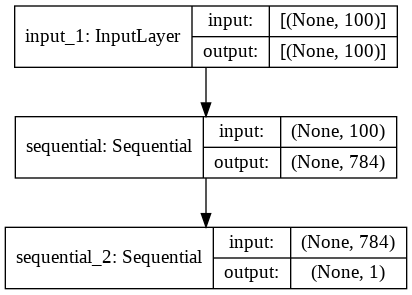

In [8]:
def create_gan(discriminator, generator):
    
    # Freeze the weights
    discriminator.trainable=False
    
    # Initialize random noise with generator
    gan_input = Input(shape=(100,))
    x = generator(gan_input)
    gan_output = discriminator(x)
    
    gan = Model(inputs = gan_input, outputs = gan_output)
    
    gan.compile(loss = 'binary_crossentropy', 
                optimizer = 'adam')
    return gan

gan = create_gan(d,g)
gan.summary()
plot_model(gan, show_shapes=True, show_layer_names=True)

<div align='justify'>Before we start training the model, we will write a function plot_generated_images to plot the generated images. This way we can see how the images are generated. We save the generated images to file that we can view later</div>

# 3. Training

In [9]:
def plot_generated_images(epoch, generator, examples=100, dim=(10,10), figsize=(10,10)):
    
    noise = np.random.normal(loc=0, scale=1, size=[examples, 100])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(100,28,28)
    
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], 
                   interpolation = 'nearest', 
                   cmap = 'gray')
        plt.axis('off')
    plt.tight_layout()

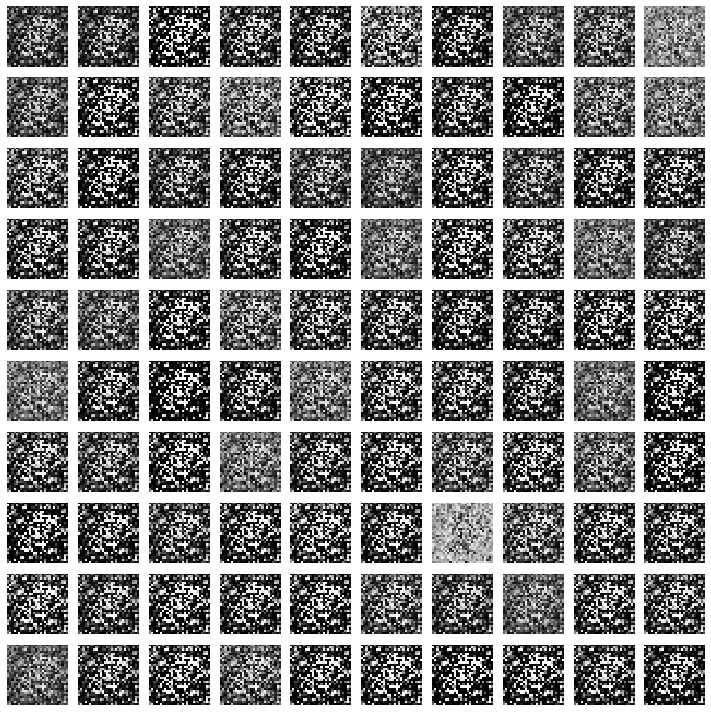

In [12]:
def training(epochs=1, batch_size=128):
    
    #Loading the data
    (X_train, y_train, X_test, y_test) = load_data(from_MNIST = False)
    batch_count = X_train.shape[0] / batch_size
    
    # Creating GAN
    generator= create_generator()
    discriminator= create_discriminator()
    gan = create_gan(discriminator, generator)
    
    for e in range(1,epochs+1 ):
        #print("Epoch %d" %e)
        #tqdm()
        for _ in range(batch_size):
        #generate  random noise as an input  to  initialize the  generator
            noise= np.random.normal(0,1, [batch_size, 100])
            
            # Generate fake MNIST images from noised input
            generated_images = generator.predict(noise)
            
            # Get a random set of  real images
            image_batch = X_train[np.random.randint(low=0,high=X_train.shape[0],size=batch_size)]
            
            #Construct different batches of  real and fake data 
            X= np.concatenate([image_batch, generated_images])
            
            # Labels for generated and real data
            y_dis=np.zeros(2*batch_size)
            y_dis[:batch_size]=0.9
            
            #Pre train discriminator on  fake and real data  before starting the gan. 
            discriminator.trainable=True
            discriminator.train_on_batch(X, y_dis)
            
            #Tricking the noised input of the Generator as real data
            noise= np.random.normal(0,1, [batch_size, 100])
            y_gen = np.ones(batch_size)
            
            # During the training of gan, 
            # the weights of discriminator should be fixed. 
            #We can enforce that by setting the trainable flag
            discriminator.trainable=False
            
            #training  the GAN by alternating the training of the Discriminator 
            #and training the chained GAN model with Discriminator’s weights freezed.
            gan.train_on_batch(noise, y_gen)
            
        if e == 1 or e % 20 == 0:
           
            plot_generated_images(e, generator)

training(1,128)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys


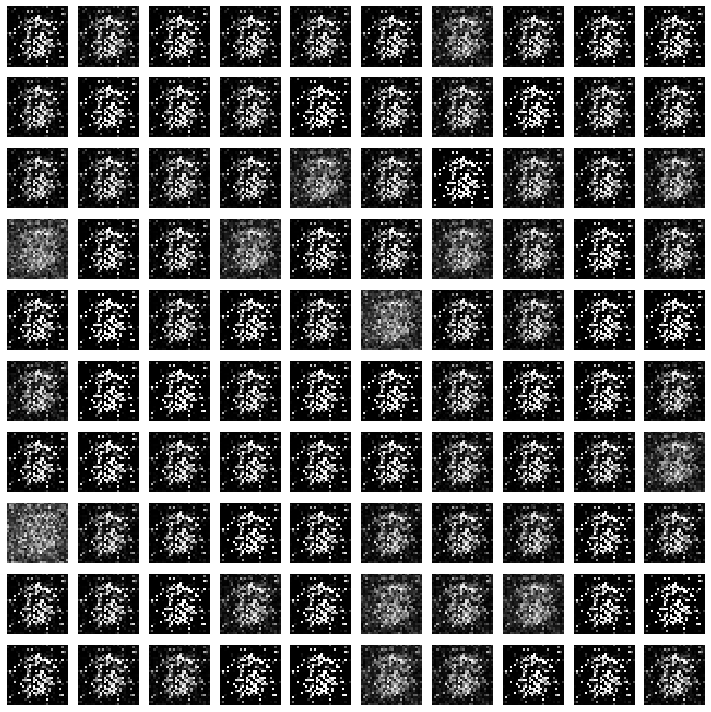

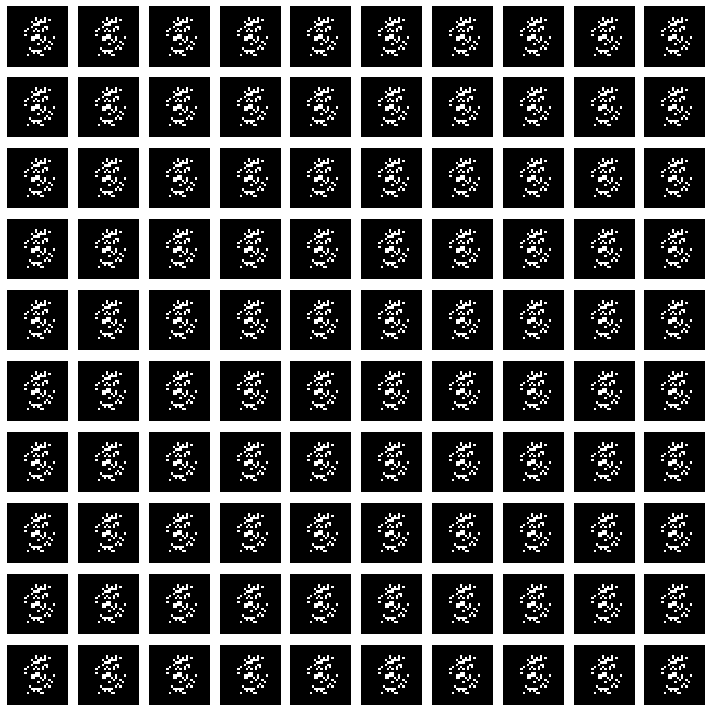

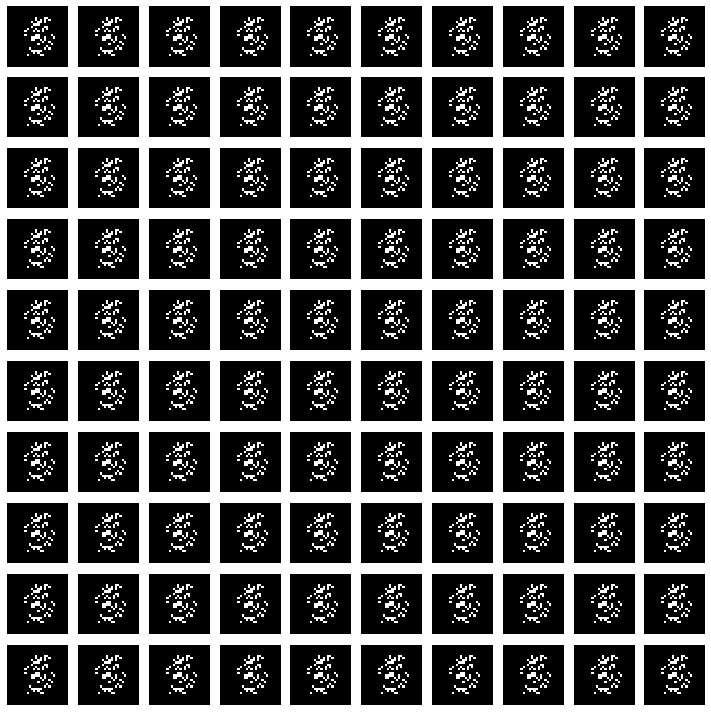

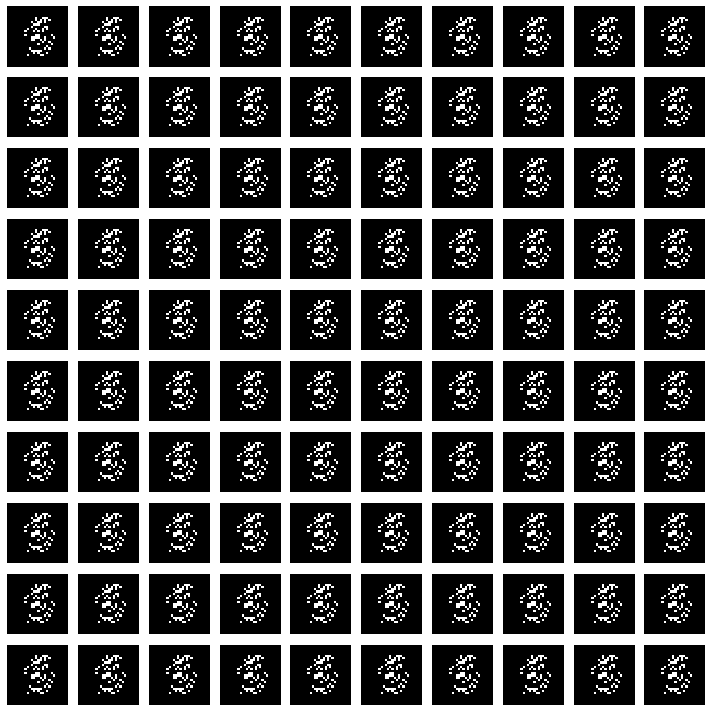

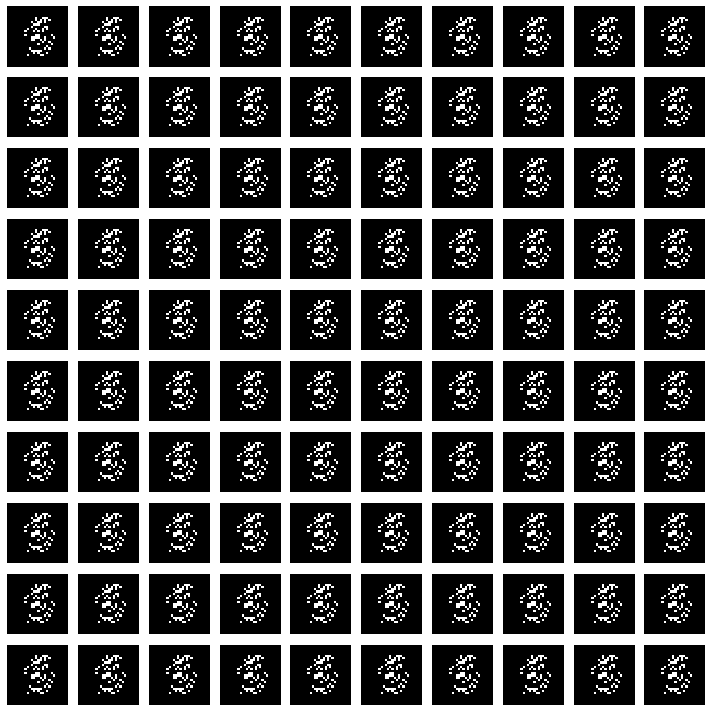

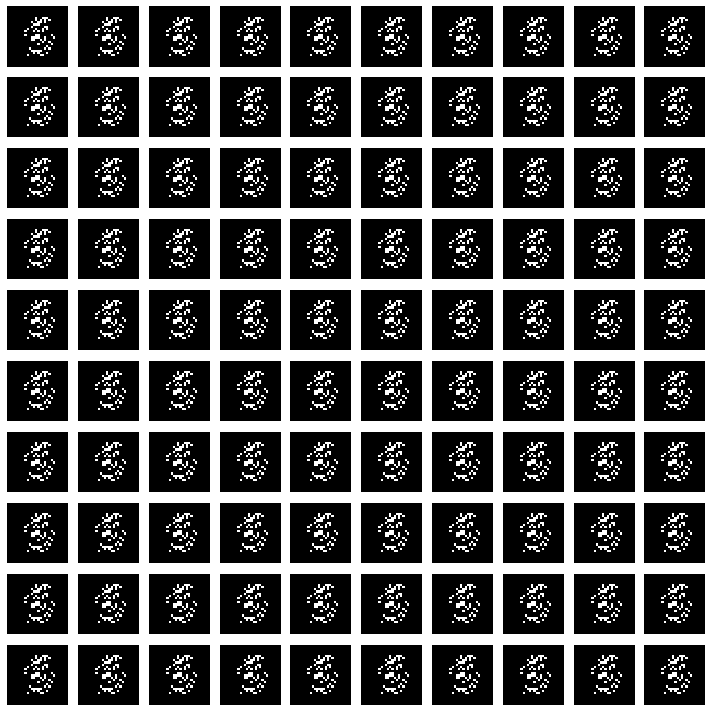

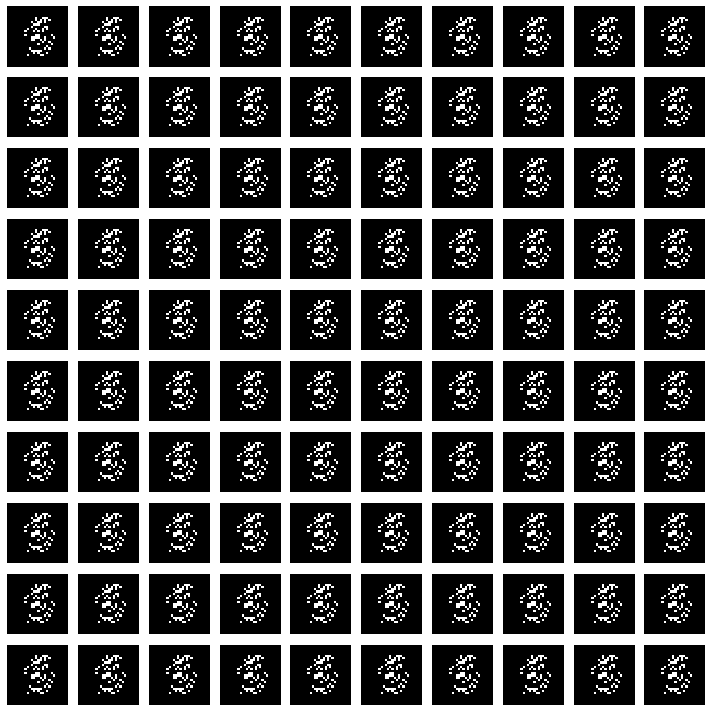

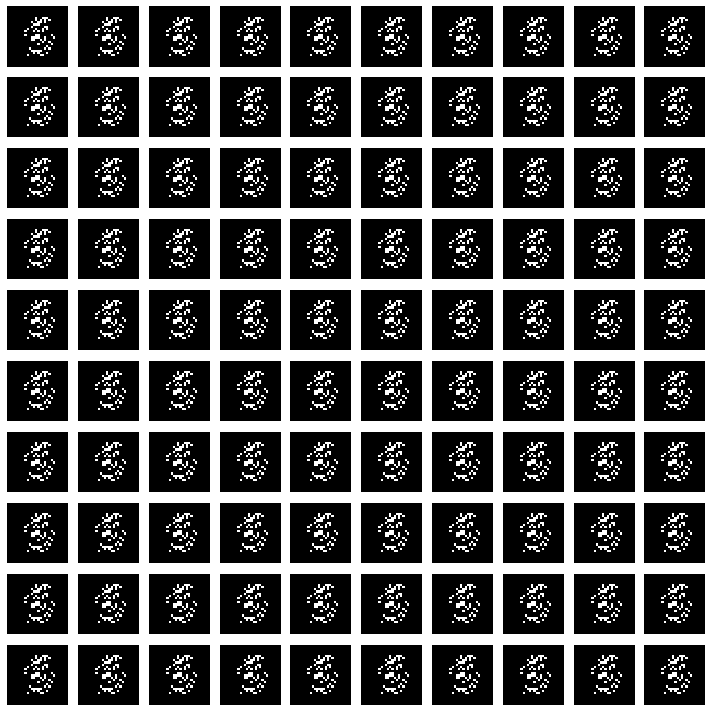

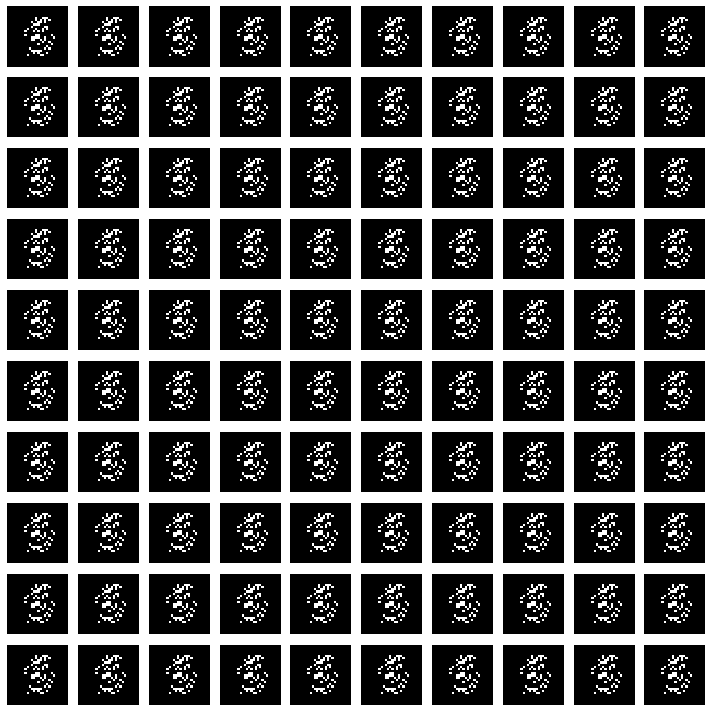

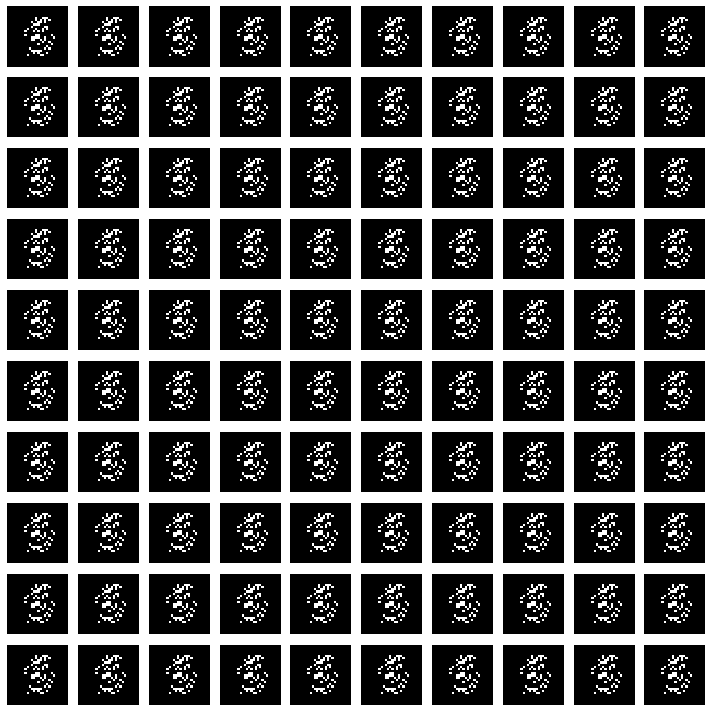

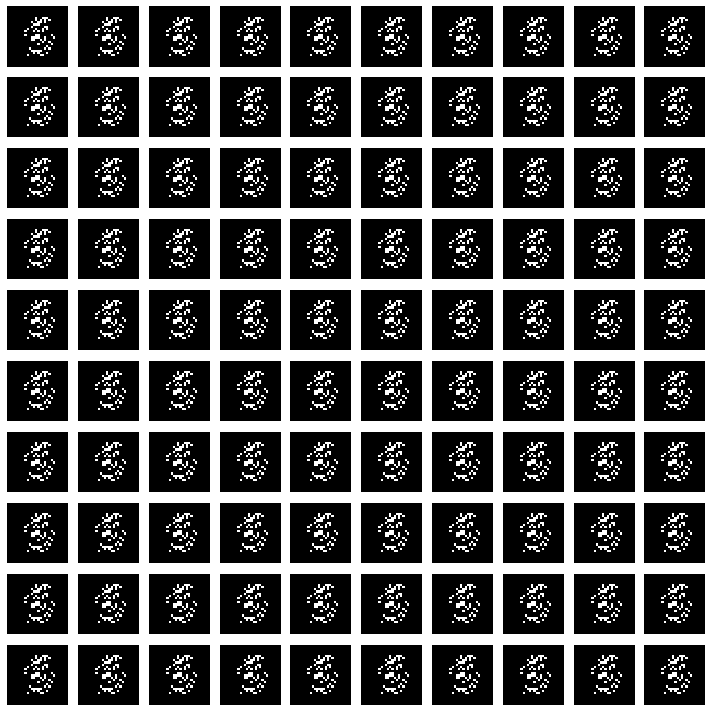

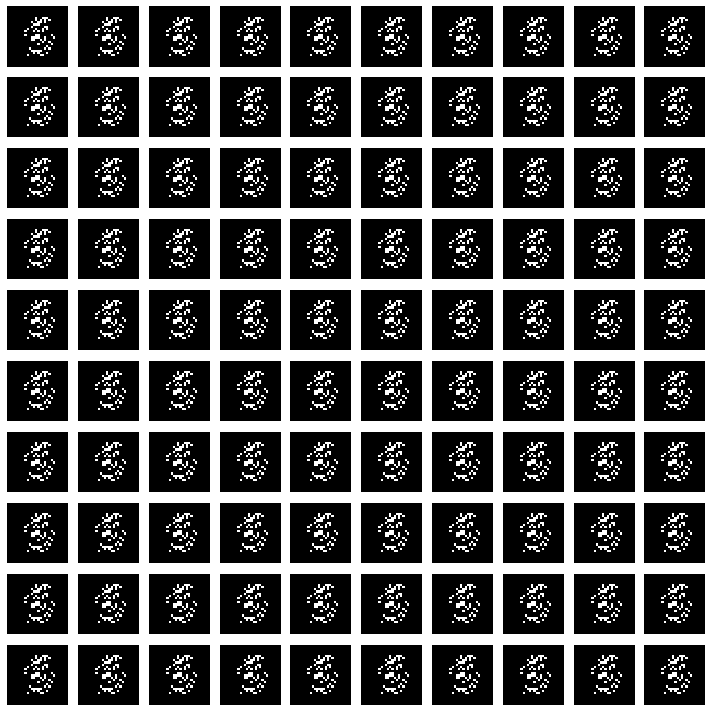

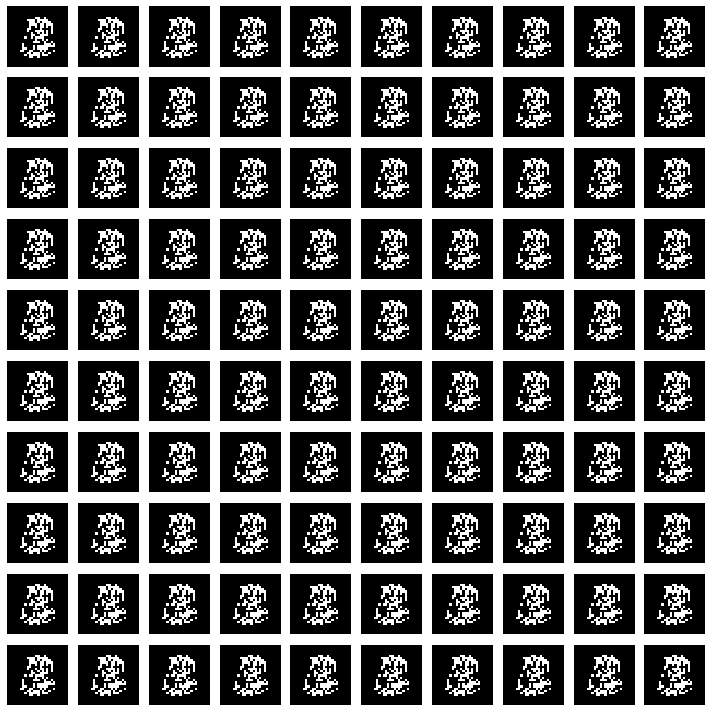

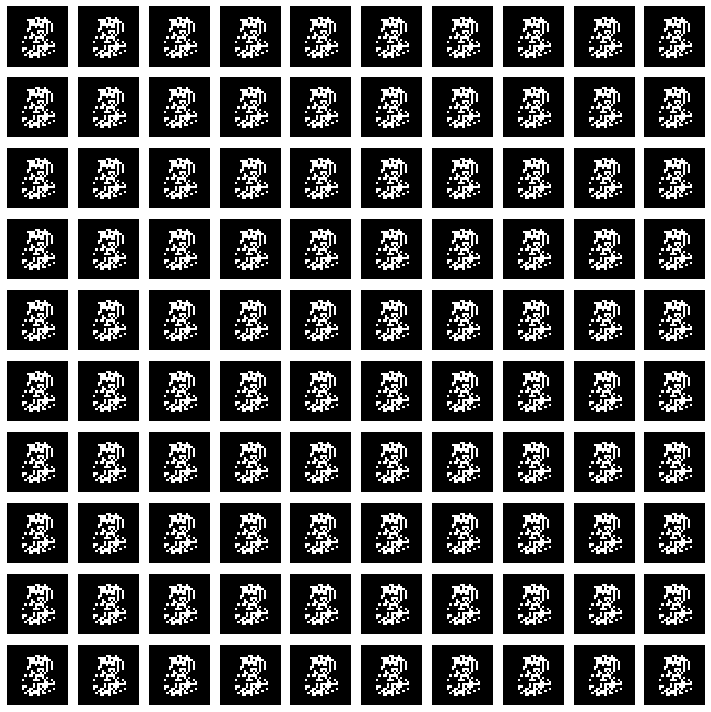

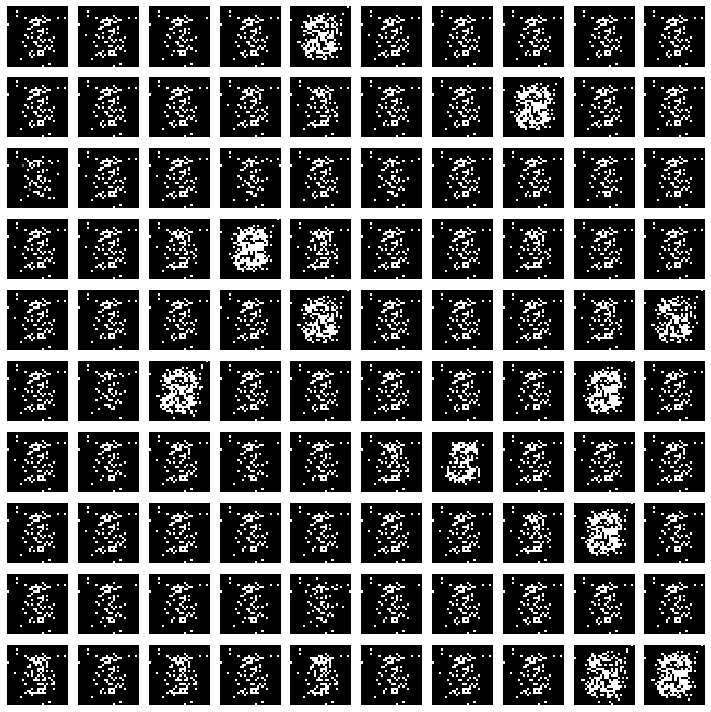

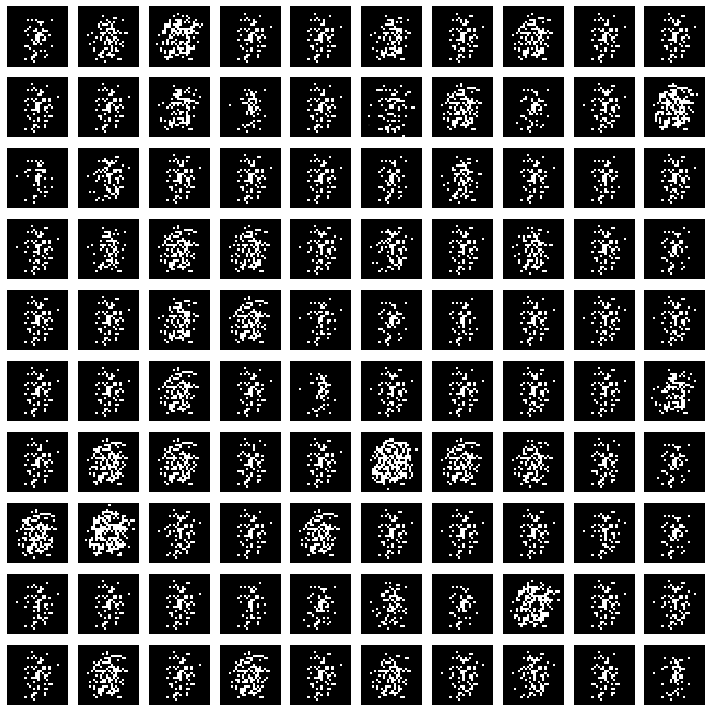

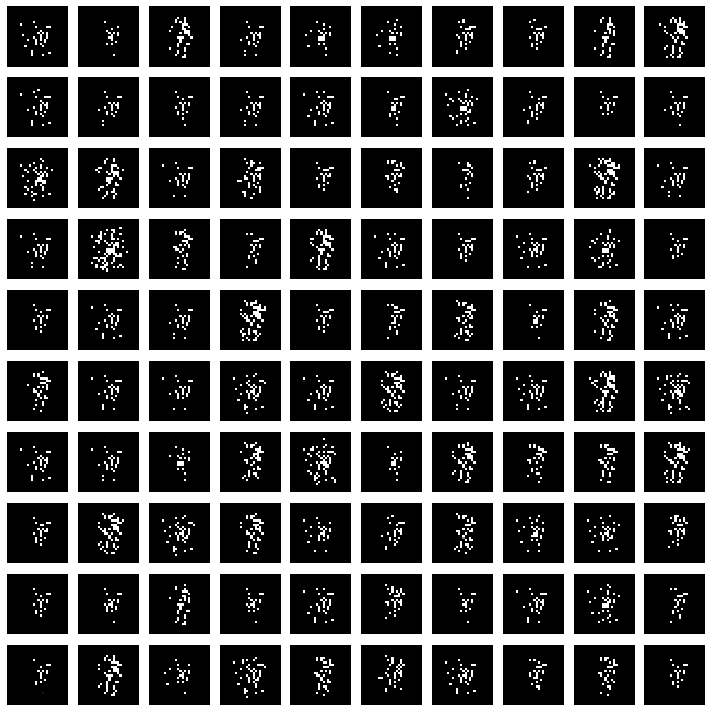

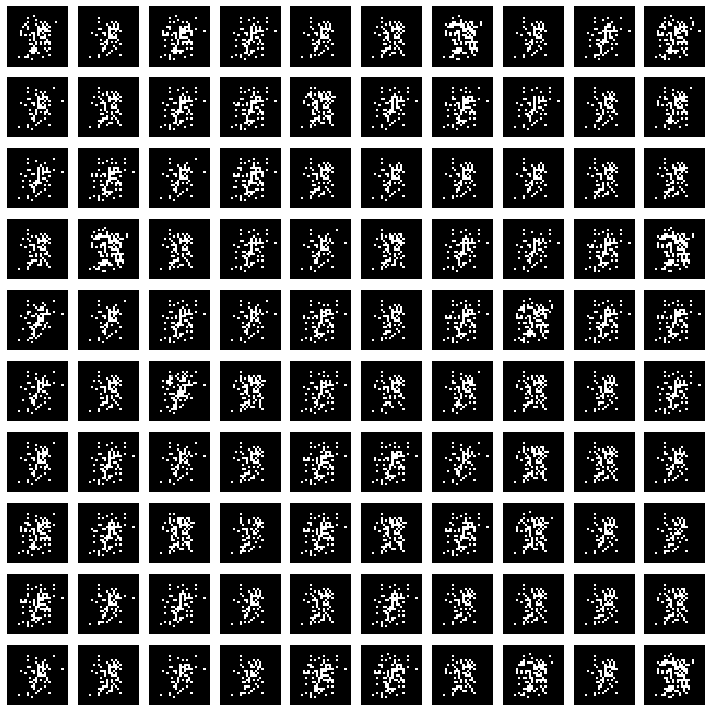

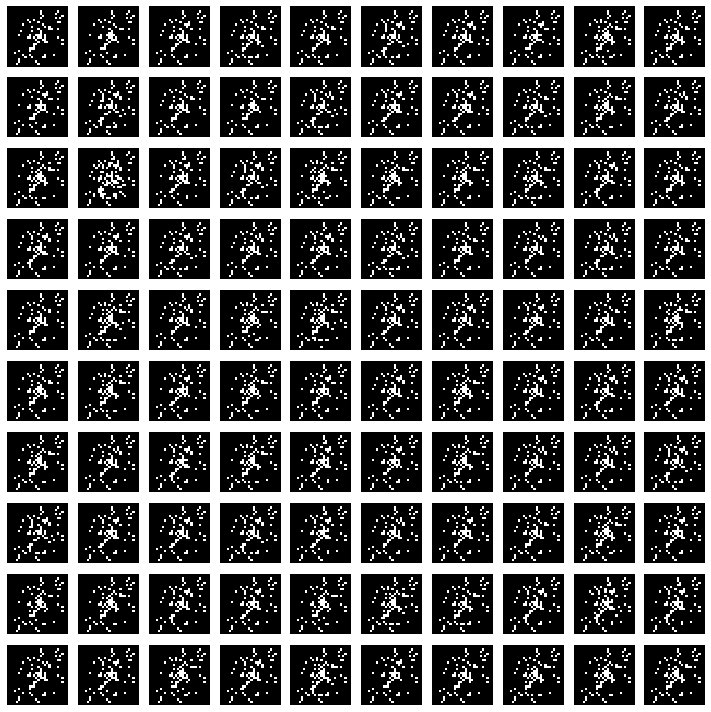

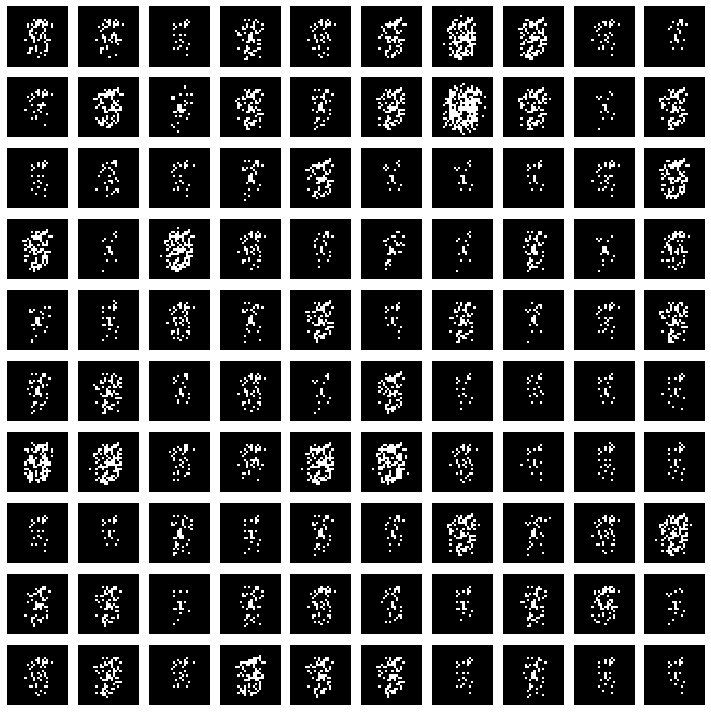

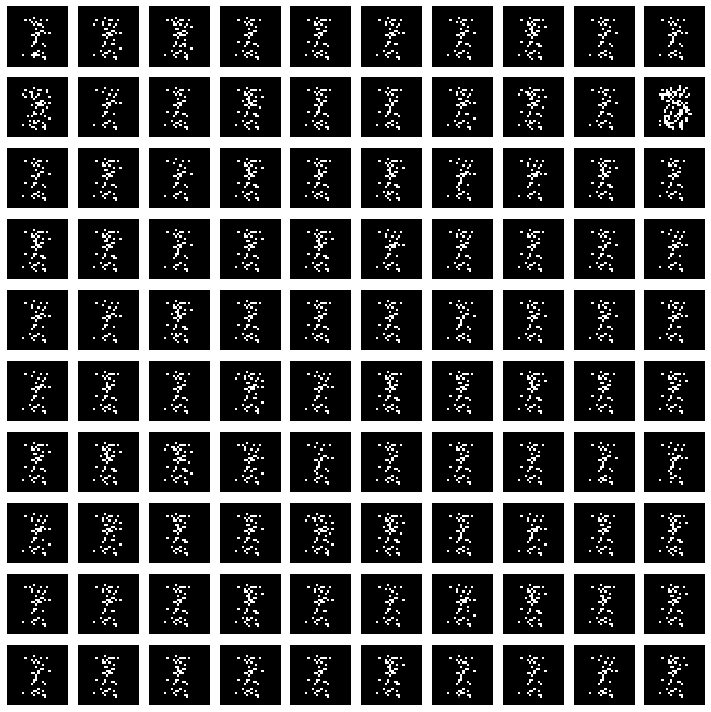

In [ ]:
def training(epochs=1, batch_size=128):
    
    #Loading the data
    (X_train, y_train, X_test, y_test) = load_data(from_MNIST = False)
    batch_count = X_train.shape[0] / batch_size
    
    # Creating GAN
    generator= create_generator()
    discriminator= create_discriminator()
    gan = create_gan(discriminator, generator)
    
    for e in range(1,epochs+1 ):
        #print("Epoch %d" %e)
        #tqdm()
        for _ in range(batch_size):
        #generate  random noise as an input  to  initialize the  generator
            noise= np.random.normal(0,1, [batch_size, 100])
            
            # Generate fake MNIST images from noised input
            generated_images = generator.predict(noise)
            
            # Get a random set of  real images
            image_batch = X_train[np.random.randint(low=0,high=X_train.shape[0],size=batch_size)]
            
            #Construct different batches of  real and fake data 
            X= np.concatenate([image_batch, generated_images])
            
            # Labels for generated and real data
            y_dis=np.zeros(2*batch_size)
            y_dis[:batch_size]=0.9
            
            #Pre train discriminator on  fake and real data  before starting the gan. 
            discriminator.trainable=True
            discriminator.train_on_batch(X, y_dis)
            
            #Tricking the noised input of the Generator as real data
            noise= np.random.normal(0,1, [batch_size, 100])
            y_gen = np.ones(batch_size)
            
            # During the training of gan, 
            # the weights of discriminator should be fixed. 
            #We can enforce that by setting the trainable flag
            discriminator.trainable=False
            
            #training  the GAN by alternating the training of the Discriminator 
            #and training the chained GAN model with Discriminator’s weights freezed.
            gan.train_on_batch(noise, y_gen)
            
        if e == 1 or e % 20 == 0:
           
            plot_generated_images(e, generator)

training(400,128)

# References

* <a href="https://www.kaggle.com/getting-started/150948">GANs research papers</a>
* <a href="https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-an-mnist-handwritten-digits-from-scratch-in-keras/">GAN tutorial</a>
* <a href="https://towardsdatascience.com/what-is-a-gan-d201752ec615">What is a GAN</a>
* <a href="https://towardsdatascience.com/generating-modern-arts-using-generative-adversarial-network-gan-on-spell-39f67f83c7b4">Maths behind the GAN</a>
